<a href="https://colab.research.google.com/github/singhpratham19/fsd/blob/main/fraud_detection_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Core libraries
import numpy as np
import pandas as pd

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
plt.style.use("default")
sns.set()

print("Libraries imported ✅")



Libraries imported ✅


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random

random.seed(42)
np.random.seed(42)

N = 20000  # number of transactions
n_customers = 5000

transaction_types = ['Online', 'POS', 'ATM', 'Transfer']
merchant_categories = ['Retail', 'Travel', 'Food', 'Entertainment', 'Gaming', 'Crypto', 'Utilities', 'Healthcare', 'Education', 'Gambling']
countries = ['India', 'USA', 'UK', 'UAE', 'Germany', 'Canada', 'Australia', 'Singapore', 'China', 'Brazil']
device_types = ['Mobile', 'Laptop', 'Tablet', 'ATM Machine', 'POS Terminal']

# Create customers with home country and known devices
customer_ids = [f"CUST-{10000+i}" for i in range(n_customers)]
customer_home_country = np.random.choice(
    countries, size=n_customers,
    p=[0.4,0.12,0.08,0.06,0.06,0.06,0.06,0.06,0.05,0.05]
)
customer_known_devices = [
    set(np.random.choice(device_types, size=np.random.randint(1,3), replace=False))
    for _ in range(n_customers)
]

rows = []
base_date = datetime(2021,1,1)

for i in range(N):
    tx_id = f"TX-{200000+i}"
    cust_idx = np.random.randint(0, n_customers)
    customer_id = customer_ids[cust_idx]
    home_country = customer_home_country[cust_idx]

    days_offset = np.random.randint(0, 365*2)
    seconds_offset = np.random.randint(0, 24*3600)
    timestamp = base_date + timedelta(days=int(days_offset), seconds=int(seconds_offset))

    tx_type = np.random.choice(transaction_types, p=[0.5,0.25,0.15,0.1])
    merchant = np.random.choice(merchant_categories, p=[0.2,0.12,0.15,0.12,0.08,0.06,0.12,0.06,0.05,0.04])

    # Amount (lognormal) scaled by merchant risk
    base_amount = np.random.lognormal(mean=3.5, sigma=1.2)
    merchant_multiplier = {
        'Retail':1.0, 'Travel':3.0, 'Food':0.8, 'Entertainment':1.2,
        'Gaming':1.5, 'Crypto':6.0, 'Utilities':0.6, 'Healthcare':2.0,
        'Education':1.0, 'Gambling':4.0
    }[merchant]
    amount = round(base_amount * merchant_multiplier, 2)

    # Card present
    card_present = 'No' if tx_type in ['Online','Transfer'] and np.random.rand()<0.8 else 'Yes'

    # Device
    if tx_type == 'ATM':
        device = 'ATM Machine'
    elif tx_type == 'POS':
        device = 'POS Terminal'
    else:
        # sometimes a new (unknown) device
        if np.random.rand() < 0.05:
            device = np.random.choice(device_types)
        else:
            device = np.random.choice(list(customer_known_devices[cust_idx]))

    # Country (sometimes foreign)
    if np.random.rand() < 0.03:
        country = np.random.choice([c for c in countries if c != home_country])
    else:
        country = home_country

    rows.append({
        'TransactionID': tx_id,
        'CustomerID': customer_id,
        'Timestamp': timestamp,
        'TransactionType': tx_type,
        'MerchantCategory': merchant,
        'Amount': amount,
        'CardPresent': card_present,
        'DeviceType': device,
        'Country': country,
        'HomeCountry': home_country
    })

df = pd.DataFrame(rows)

df.head()

,TransactionID,CustomerID,Timestamp,TransactionType,MerchantCategory,Amount,CardPresent,DeviceType,Country,HomeCountry
0,TX-200000,CUST-11989,2021-04-19 02:16:14,Online,Retail,20.02,No,ATM Machine,Canada,Canada
1,TX-200001,CUST-14875,2021-06-19 01:46:27,POS,Food,17.43,Yes,POS Terminal,UAE,UAE
2,TX-200002,CUST-13012,2021-11-13 18:55:46,POS,Food,307.51,Yes,POS Terminal,India,India
3,TX-200003,CUST-11688,2022-01-03 11:22:45,Online,Travel,205.98,No,Mobile,UAE,UAE
4,TX-200004,CUST-12815,2022-10-01 17:57:22,Online,Entertainment,34.87,Yes,ATM Machine,Canada,Canada


In [4]:
# Sort by customer and time
df = df.sort_values(['CustomerID','Timestamp']).reset_index(drop=True)

# Basic time features
df['Hour'] = df['Timestamp'].dt.hour
df['IsNight'] = df['Hour'].between(0,4).astype(int)
df['IsForeign'] = (df['Country'] != df['HomeCountry']).astype(int)

# DeviceNovel: device not in original known devices
known_devices_map = {customer_ids[i]: set(customer_known_devices[i]) for i in range(n_customers)}
device_novel = []

for idx, row in df.iterrows():
    cust = row['CustomerID']
    dev = row['DeviceType']
    if dev not in known_devices_map[cust]:
        device_novel.append(1)
        if np.random.rand() < 0.2:
            known_devices_map[cust].add(dev)
    else:
        device_novel.append(0)

df['DeviceNovel'] = device_novel

# Previous timestamp per customer
df['PrevTimestamp'] = df.groupby('CustomerID')['Timestamp'].shift(1)
df['SecondsSincePrev'] = (df['Timestamp'] - df['PrevTimestamp']).dt.total_seconds().fillna(999999)
df['RapidSeq'] = (df['SecondsSincePrev'] <= 600).astype(int)  # 10 minutes window

# Risk tables
merchant_risk = {
    m: r for m, r in zip(
        ['Retail','Travel','Food','Entertainment','Gaming','Crypto','Utilities','Healthcare','Education','Gambling'],
        [0.02,0.04,0.01,0.03,0.05,0.12,0.015,0.02,0.01,0.10]
    )
}
type_risk = {'Online':0.03, 'POS':0.01, 'ATM':0.02, 'Transfer':0.04}

def compute_fraud_prob(row):
    prob = 0.001
    prob += merchant_risk.get(row['MerchantCategory'], 0.01)
    prob += type_risk.get(row['TransactionType'], 0.01)

    if row['Amount'] > 5000:
        prob += 0.05
    if row['Amount'] > 20000:
        prob += 0.10
    if row['IsNight'] == 1:
        prob += 0.02
    if row['IsForeign'] == 1:
        prob += 0.06
    if row['DeviceNovel'] == 1:
        prob += 0.03
    if row['CardPresent'] == 'No' and row['Amount'] > 2000:
        prob += 0.04
    if row['RapidSeq'] == 1:
        prob += 0.03

    prob += np.random.normal(0, 0.005)
    return min(max(prob, 0), 0.99)

df['FraudProb'] = df.apply(compute_fraud_prob, axis=1)

# ~4% fraud: top 4% highest probability as fraud
threshold = df['FraudProb'].quantile(0.96)
df['FraudFlag'] = (df['FraudProb'] >= threshold).astype(int)

# Little label noise
flip_idxs = np.random.choice(df.index, size=int(0.002 * len(df)), replace=False)
df.loc[flip_idxs, 'FraudFlag'] = 1 - df.loc[flip_idxs, 'FraudFlag']

df[['FraudProb','FraudFlag']].head()


,FraudProb,FraudFlag
0,0.098598,0
1,0.135240,0
2,0.064231,0
3,0.050971,0
4,0.061467,0


In [5]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

print("\nMissing values:\n", df.isnull().sum())

print("\nFraud distribution (%):")
print(df['FraudFlag'].value_counts(normalize=True).mul(100).round(2))

df.describe(include='all').transpose().head(15)

Shape: (20000, 19)

Columns:
 ['TransactionID', 'CustomerID', 'Timestamp', 'TransactionType', 'MerchantCategory', 'Amount', 'CardPresent', 'DeviceType', 'Country', 'HomeCountry', 'Hour', 'IsNight', 'IsForeign', 'DeviceNovel', 'PrevTimestamp', 'SecondsSincePrev', 'RapidSeq', 'FraudProb', 'FraudFlag']

Missing values:
 TransactionID          0
CustomerID             0
Timestamp              0
TransactionType        0
MerchantCategory       0
Amount                 0
CardPresent            0
DeviceType             0
Country                0
HomeCountry            0
Hour                   0
IsNight                0
IsForeign              0
DeviceNovel            0
PrevTimestamp       4916
SecondsSincePrev       0
RapidSeq               0
FraudProb              0
FraudFlag              0
dtype: int64

Fraud distribution (%):
FraudFlag
0    95.83
1     4.17
Name: proportion, dtype: float64


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
TransactionID,20000,20000,TX-214573,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerID,20000,4916,CUST-14525,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timestamp,20000,NaN,NaN,NaN,2021-12-30 21:13:37.886550016,2021-01-01 01:34:05,2021-06-30 09:22:26.500000,2021-12-30 15:34:10,2022-06-30 12:18:31,2022-12-31 22:22:31,NaN
TransactionType,20000,4,Online,9947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MerchantCategory,20000,10,Retail,4051,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,20000.0,NaN,NaN,NaN,116.665764,0.14,18.0775,44.435,111.1525,7926.57,263.596532
CardPresent,20000,2,Yes,10547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeviceType,20000,5,POS Terminal,7528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,20000,10,India,7861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomeCountry,20000,10,India,8058,NaN,NaN,NaN,NaN,NaN,NaN,NaN


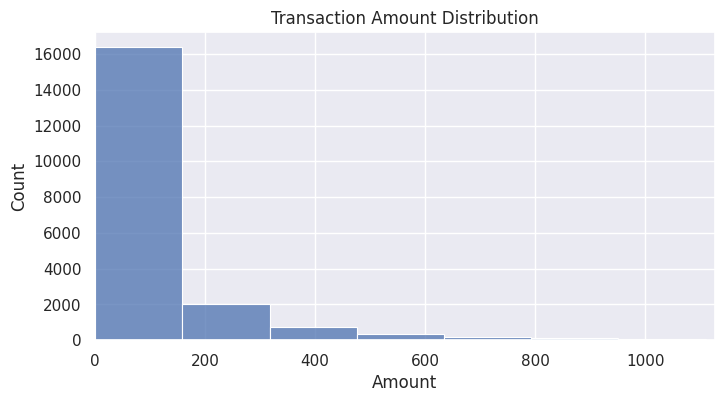

In [6]:
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=50)
plt.xlim(0, df['Amount'].quantile(0.99))  # zoom in, ignore crazy tails
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.show()

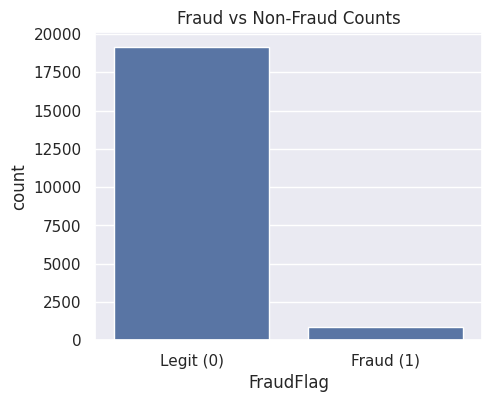

In [7]:
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='FraudFlag')
plt.title("Fraud vs Non-Fraud Counts")
plt.xticks([0,1], ['Legit (0)','Fraud (1)'])
plt.show()

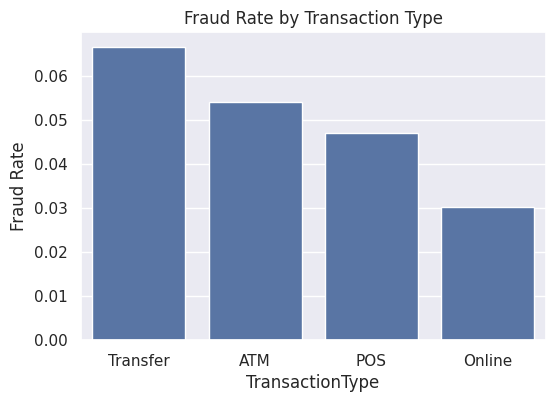

,FraudFlag
TransactionType,
Transfer,0.066532
ATM,0.054028
POS,0.047059
Online,0.030260


In [8]:
fraud_by_type = df.groupby('TransactionType')['FraudFlag'].mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.show()

fraud_by_type

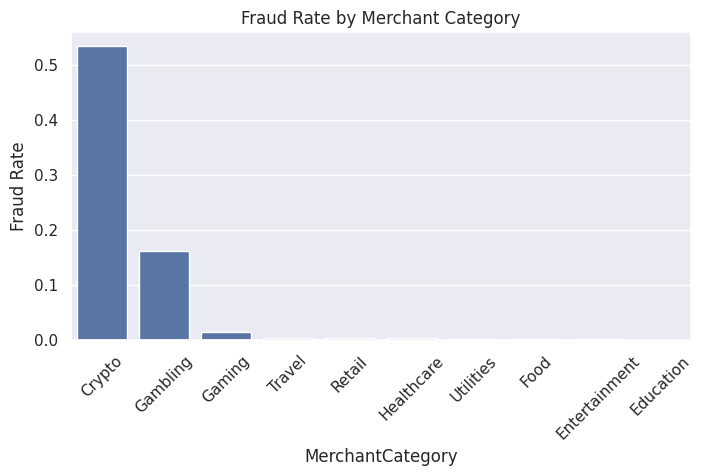

,FraudFlag
MerchantCategory,
Crypto,0.533442
Gambling,0.160256
Gaming,0.014136
Travel,0.003326
Retail,0.002962
Healthcare,0.002477
Utilities,0.001676
Food,0.001022
Entertainment,0.000844


In [9]:
fraud_by_merchant = df.groupby('MerchantCategory')['FraudFlag'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=fraud_by_merchant.index, y=fraud_by_merchant.values)
plt.title("Fraud Rate by Merchant Category")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()

fraud_by_merchant.head(10)

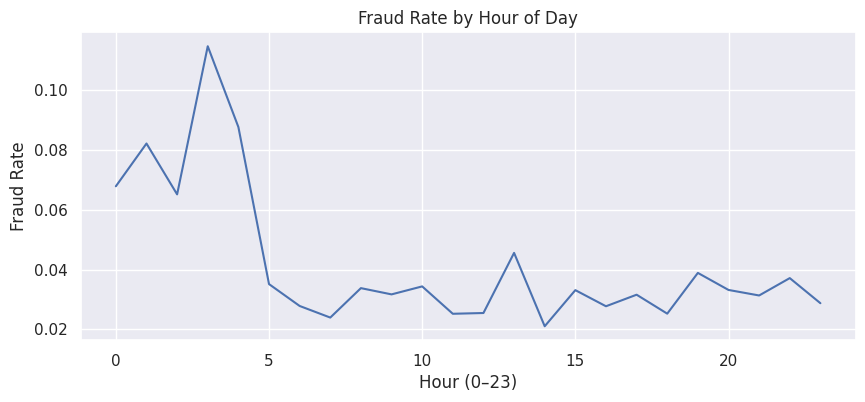

,FraudFlag
Hour,
0,0.067839
1,0.082143
2,0.065134
3,0.114673
4,0.087654
5,0.035129
6,0.027811
7,0.023929
8,0.033776


In [10]:
# Fraud by hour
fraud_by_hour = df.groupby('Hour')['FraudFlag'].mean()

plt.figure(figsize=(10,4))
sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour.values)
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Fraud Rate")
plt.grid(True)
plt.show()

fraud_by_hour

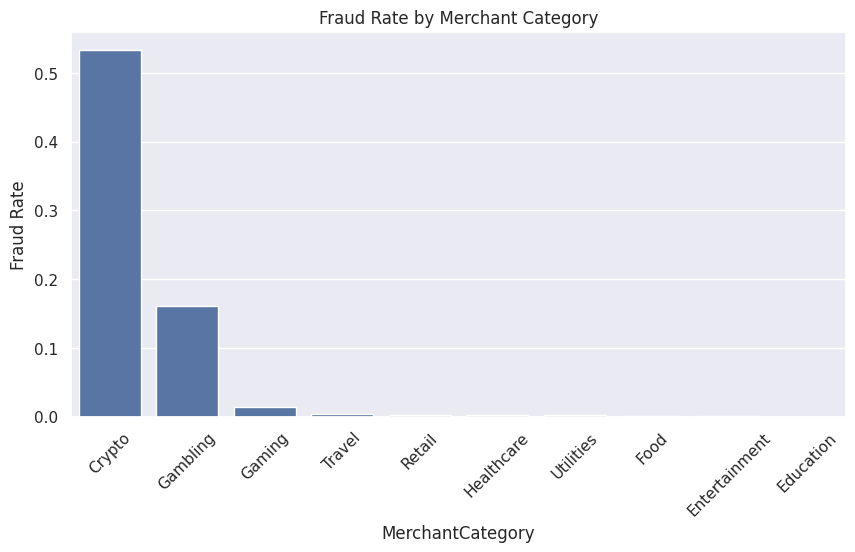

,FraudFlag
MerchantCategory,
Crypto,0.533442
Gambling,0.160256
Gaming,0.014136
Travel,0.003326
Retail,0.002962
Healthcare,0.002477
Utilities,0.001676
Food,0.001022
Entertainment,0.000844


In [11]:
fraud_by_merchant = df.groupby('MerchantCategory')['FraudFlag'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=fraud_by_merchant.index, y=fraud_by_merchant.values)
plt.xticks(rotation=45)
plt.title("Fraud Rate by Merchant Category")
plt.ylabel("Fraud Rate")
plt.show()

fraud_by_merchant.head(10)

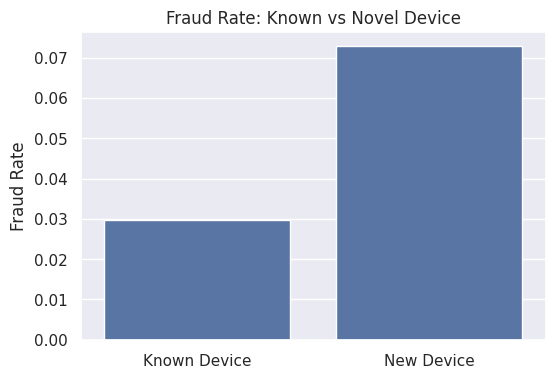

In [12]:
plt.figure(figsize=(6,4))
sns.barplot(x=['Known Device','New Device'],
            y=df.groupby('DeviceNovel')['FraudFlag'].mean().values)
plt.title("Fraud Rate: Known vs Novel Device")
plt.ylabel("Fraud Rate")
plt.show()

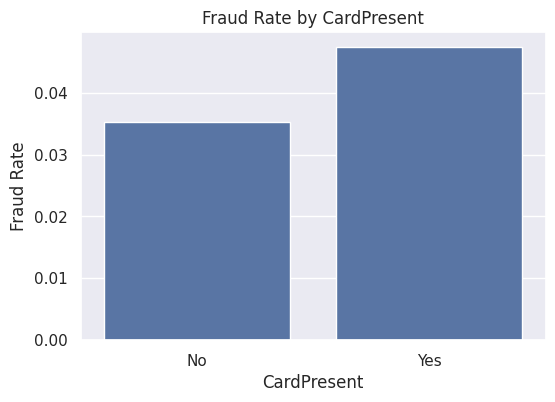

,FraudFlag
CardPresent,
No,0.035333
Yes,0.047407


In [13]:
fraud_by_cnp = df.groupby('CardPresent')['FraudFlag'].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=fraud_by_cnp.index, y=fraud_by_cnp.values)
plt.title("Fraud Rate by CardPresent")
plt.ylabel("Fraud Rate")
plt.show()

fraud_by_cnp

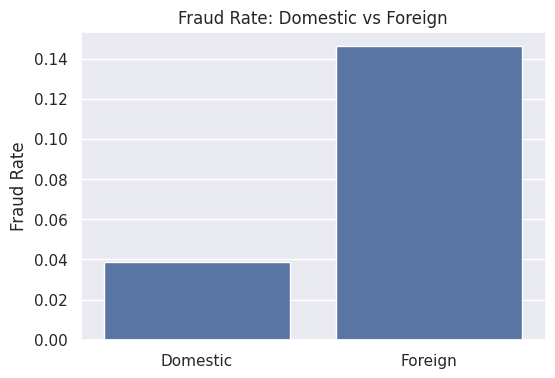

,FraudFlag
IsForeign,
0,0.038572
1,0.146048


In [14]:
fraud_by_foreign = df.groupby('IsForeign')['FraudFlag'].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=['Domestic','Foreign'],
            y=fraud_by_foreign.values)
plt.title("Fraud Rate: Domestic vs Foreign")
plt.ylabel("Fraud Rate")
plt.show()

fraud_by_foreign

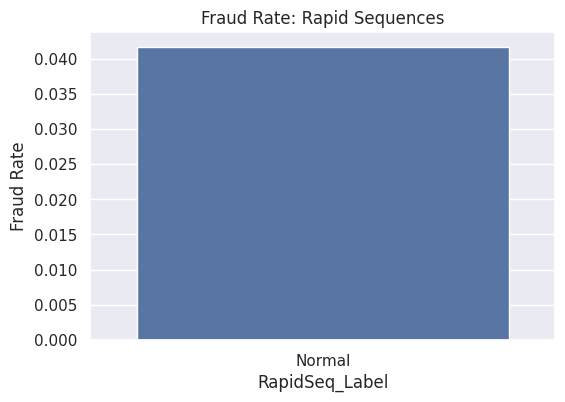

In [16]:
rapid_seq_data = df.groupby('RapidSeq')['FraudFlag'].mean().reset_index()
rapid_seq_data['RapidSeq_Label'] = rapid_seq_data['RapidSeq'].map({0: 'Normal', 1: 'Rapid (<=600 sec)'})

plt.figure(figsize=(6,4))
sns.barplot(x='RapidSeq_Label', y='FraudFlag', data=rapid_seq_data)
plt.title("Fraud Rate: Rapid Sequences")
plt.ylabel("Fraud Rate")
plt.show()

In [17]:
# Normalize amount
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['AmtScaled'] = scaler.fit_transform(df[['Amount']])

# Merchant risk dictionary
merchant_risk = {
    'Retail':0.02,'Travel':0.05,'Food':0.01,'Entertainment':0.03,
    'Gaming':0.04,'Crypto':0.12,'Utilities':0.005,'Healthcare':0.02,
    'Education':0.005,'Gambling':0.10
}

df['MerchantRisk'] = df['MerchantCategory'].map(merchant_risk)

# Card not present
df['CardNotPresent'] = (df['CardPresent'] == 'No').astype(int)

# Risk Score: weighted sum of indicators
df['RiskScore'] = (
    0.35 * df['AmtScaled'] +
    0.15 * df['IsForeign'] +
    0.10 * df['DeviceNovel'] +
    0.08 * df['IsNight'] +
    0.10 * df['RapidSeq'] +
    0.10 * df['CardNotPresent'] +
    0.12 * df['MerchantRisk']
)

# Clip to 0–1
df['RiskScore'] = df['RiskScore'].clip(0,1)

# Display summary
df['RiskScore'].describe()

,RiskScore
count,20000.000000
mean,0.104709
std,0.063332
min,0.000600
25%,0.100637
50%,0.104430
75%,0.117815
max,0.542000


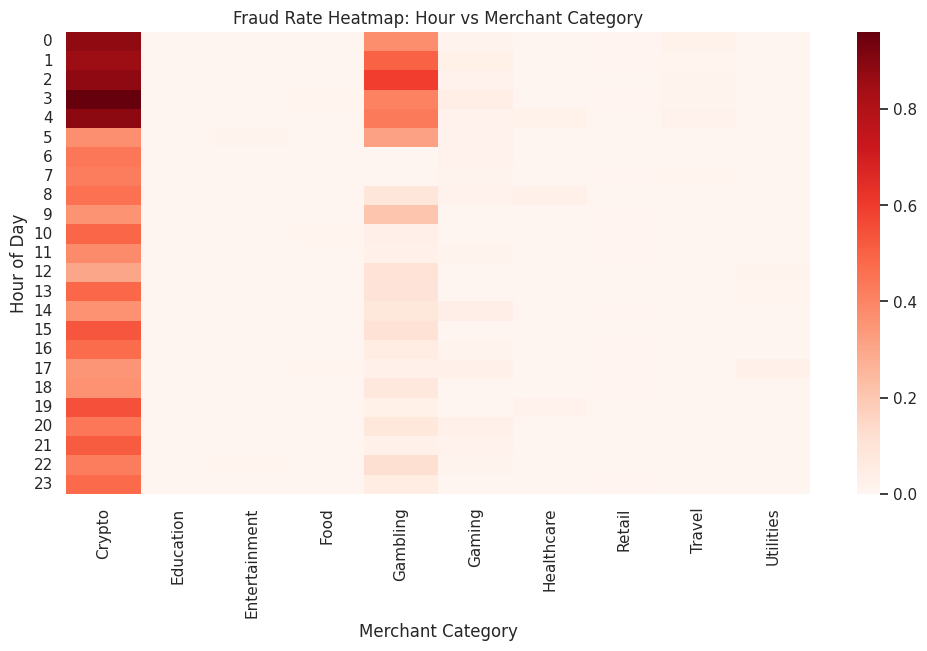

In [18]:
pivot = df.pivot_table(
    index='Hour',
    columns='MerchantCategory',
    values='FraudFlag',
    aggfunc='mean'
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Reds")
plt.title("Fraud Rate Heatmap: Hour vs Merchant Category")
plt.xlabel("Merchant Category")
plt.ylabel("Hour of Day")
plt.show()

/tmp/ipython-input-2467987802.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['FraudFlag']==0]['RiskScore'], label='Legit', shade=True)
/tmp/ipython-input-2467987802.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['FraudFlag']==1]['RiskScore'], label='Fraud', shade=True)


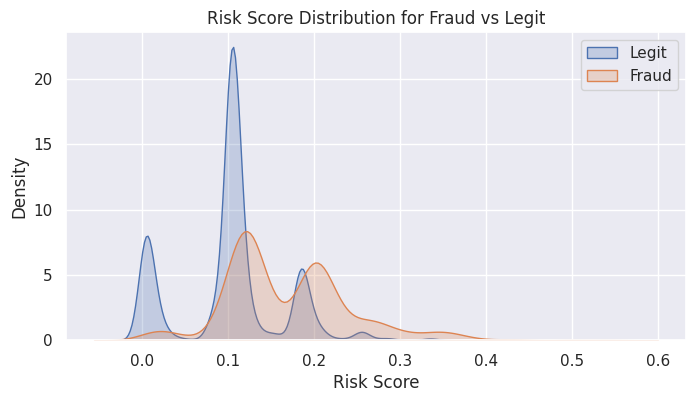

In [19]:
plt.figure(figsize=(8,4))
sns.kdeplot(df[df['FraudFlag']==0]['RiskScore'], label='Legit', shade=True)
sns.kdeplot(df[df['FraudFlag']==1]['RiskScore'], label='Fraud', shade=True)
plt.title("Risk Score Distribution for Fraud vs Legit")
plt.xlabel("Risk Score")
plt.legend()
plt.show()

In [20]:
cust_risk = df.groupby('CustomerID')['RiskScore'].mean().sort_values(ascending=False).head(10)
cust_risk

,RiskScore
CustomerID,
CUST-10383,0.336056
CUST-11073,0.319364
CUST-10525,0.264340
CUST-11340,0.264120
CUST-10184,0.263301
CUST-10553,0.261065
CUST-13392,0.260782
CUST-14213,0.257268
CUST-12291,0.255850


In [22]:
total_fraud_amount = df[df['FraudFlag']==1]['Amount'].sum()
total_fraud_count = df['FraudFlag'].sum()

total_fraud_amount, total_fraud_count

(np.float64(366651.16), np.int64(834))

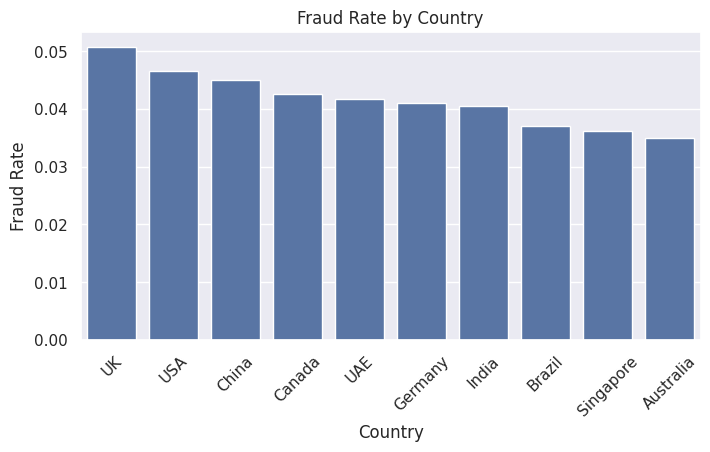

,FraudFlag
Country,
UK,0.050792
USA,0.046579
China,0.045055
Canada,0.042605
UAE,0.041798
Germany,0.040977
India,0.040580
Brazil,0.037037
Singapore,0.036095


In [23]:
fraud_by_country = df.groupby('Country')['FraudFlag'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=fraud_by_country.index, y=fraud_by_country.values)
plt.xticks(rotation=45)
plt.title("Fraud Rate by Country")
plt.ylabel("Fraud Rate")
plt.show()

fraud_by_country

In [24]:
df.to_csv("fraud_cleaned_for_tableau.csv", index=False)

In [25]:
from google.colab import files

files.download("fraud_cleaned_for_tableau.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
df['RapidSeq'].value_counts()

,count
RapidSeq,
0,20000
